# Downstream analysis pySCENIC

Downstream analysis using the loom file generated from [this notebook]("./pySCENIC_NK_mm.ipynb")

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pyscenic.utils import load_motifs
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

import warnings
warnings.filterwarnings('ignore')

In [2]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = "Results/mm_res_scenic_integrated-output.loom"

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)



## Extract relevant data from the integrated loom file


In [4]:


# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)



In [5]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)



In [6]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.new_label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.percent_mt, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.batch, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'new_label',
 'label',
 'percent_mt',
 'nGene',
 'nUMI',
 'batch']


In [7]:
# capture embeddings:

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

dr = pd.DataFrame()
dr.index = drx.index
dr["X"] = drx
dr["Y"] = dry




In [8]:
lf.close()

### Using anndata

In [9]:
adata = sc.read( f_final_loom, validate=False)

# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [10]:
adata.obsm["X_umap"] = np.array(dr)

In [11]:
sc._utils.sanitize_anndata( adata )

In [12]:
# load the regulons from a file using the load_signatures function
sig = load_signatures('Results/reg_mm_res.csv')
adata = add_scenic_metadata(adata, auc_mtx, sig)


Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [13]:
df_motifs = load_motifs('Results/reg_mm_res.csv')

In [14]:
# Z-score area under the curve for selected regulons
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)



In [15]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f


def TF_activity(label, n):
    rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot[label] )
    print(rss_cellType)
    
    cats = sorted(list(set(cellAnnot[label])))

    fig = plt.figure(figsize=(15, 8))
    for c,num in zip(cats, range(1,len(cats)+1)):
        x=rss_cellType.T[c]
        ax = fig.add_subplot(1,3,num)
        plot_rss(rss_cellType, c, top_n=n, max_n=None, ax=ax)
        ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
        for t in ax.texts:
            t.set_fontsize(12)
        ax.set_ylabel('')
        ax.set_xlabel('')
        adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )

    fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
    fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
    plt.tight_layout()
    plt.rcParams.update({
        'figure.autolayout': True,
            'figure.titlesize': 'large' ,
            'axes.labelsize': 'medium',
            'axes.titlesize':'large',
            'xtick.labelsize':'medium',
            'ytick.labelsize':'medium'
            })
    #plt.savefig("test_cell-state-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
    plt.show()
    
    # top regulons for each cell type
    topreg = []
    for i,c in enumerate(cats):
        topreg.extend(
            list(rss_cellType.T[c].sort_values(ascending=False)[:n].index)
        )
    topreg = list(set(topreg))

    colors = sns.color_palette('bright',n_colors=len(cats) )
    colorsd = dict( zip( cats, colors ))
    colormap = [ colorsd[x] for x in cellAnnot[label] ]

    sns.set()
    sns.set(font_scale=0.8)
    fig = palplot( colors, cats, size=2.0)

    sns.set(font_scale=1.2)
    g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
        yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
        cmap="YlGnBu", figsize=(21,16) )
    g.cax.set_visible(True)
    g.ax_heatmap.set_ylabel('')
    g.ax_heatmap.set_xlabel('')

    means = round(rss_cellType.T.mean(),3)
    means = means.rename("mean")
    sd = round(rss_cellType.T.std(),3)
    sd = sd.rename("StDev")
    ratio = round(adata.obs[label].value_counts()/adata.n_obs,3)
    ratio = ratio.rename("Ratio")
    specs = pd.concat([means,sd,ratio],axis=1)
    print(specs)
    
    
    return rss_cellType



In [16]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

,AHR_(+),ARID3A_(+),ARNTL_(+),ATF1_(+),ATF4_(+),ATF5_(+),ATF6_(+),ATF7_(+),BACH1_(+),BACH2_(+),...,ZNF639_(+),ZNF669_(+),ZNF675_(+),ZNF677_(+),ZNF682_(+),ZNF75A_(+),ZNF808_(+),ZNF814_(+),ZNF836_(+),ZSCAN26_(+)
MGUS_CD138nCD45p_2_GCATGTACAATCGAAA-1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
MGUS_CD138nCD45p_2_GGGTTGCAGGGAGTAA-1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
MGUS_CD138nCD45p_2_GTGGGTCCATAACCTG-1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
MGUS_CD138nCD45p_2_TACTTGTGTGGTCCGT-1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
MGUS_CD138nCD45p_2_TCTTCGGAGCTAGTTC-1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


In [17]:
def AUC_plot(rss_cellType):
    # top regulons for each cell type
    topreg = []
    for i,c in enumerate(rss_cellType.T):
        topreg = rss_cellType.loc[c].sort_values(ascending=False).index.to_list()[:5]
        topreg = list(set(topreg))
        
        fig, axs = plt.subplots(1, 5, figsize=(12, 4), dpi=150, sharey=False)
        for i,ax in enumerate(axs):
            sns.distplot(auc_mtx[ topreg[i] ], ax=ax, norm_hist=True, bins=100)
            ax.plot( [ auc_thresholds[ topreg[i] ] ]*2, ax.get_ylim(), 'r:')
            ax.title.set_text( topreg[i] )
            ax.set_xlabel('')

        fig.suptitle(c)
        fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
        fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

        fig.tight_layout()

              AHR_(+)  ARID3A_(+)  ARNTL_(+)  ATF1_(+)  ATF4_(+)  ATF5_(+)  \
NK resident  0.291145    0.806848     0.8182  0.837429   0.94036  0.315264   

             ATF6_(+)  ATF7_(+)  BACH1_(+)  BACH2_(+)  ...  ZNF639_(+)  \
NK resident  0.245639  0.515465   0.881952   0.708404  ...    0.437259   

             ZNF669_(+)  ZNF675_(+)  ZNF677_(+)  ZNF682_(+)  ZNF75A_(+)  \
NK resident      0.5672    0.767327    0.292199    0.327669    0.231793   

             ZNF808_(+)  ZNF814_(+)  ZNF836_(+)  ZSCAN26_(+)  
NK resident     0.36744    0.667096     0.49369     0.367233  

[1 rows x 231 columns]


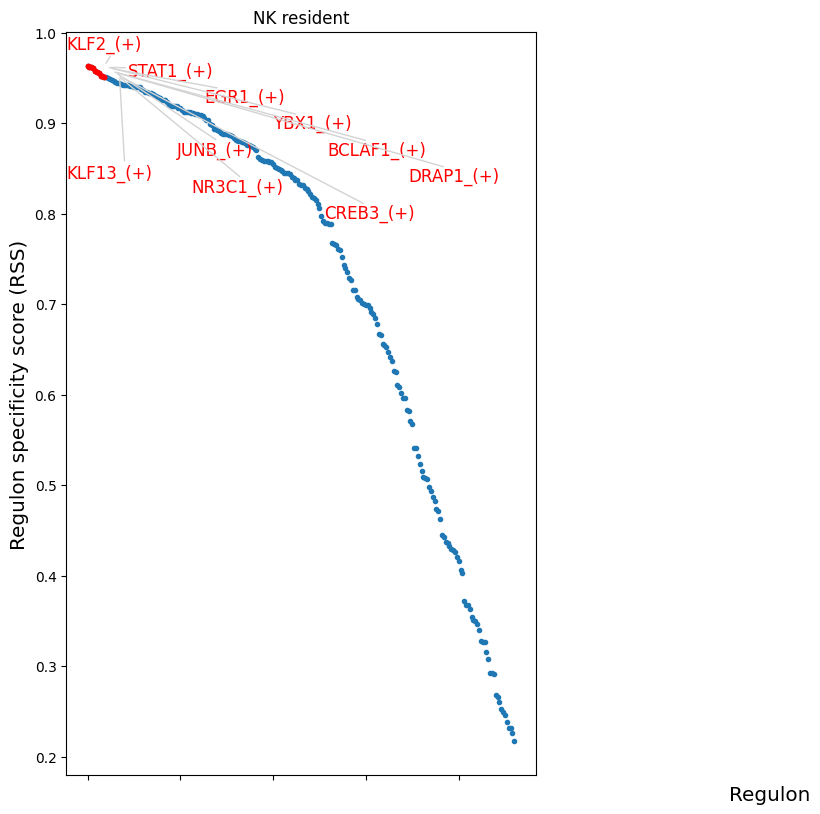

              mean  StDev  Ratio
NK resident  0.731  0.221    1.0


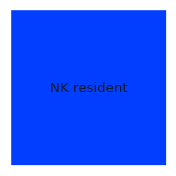

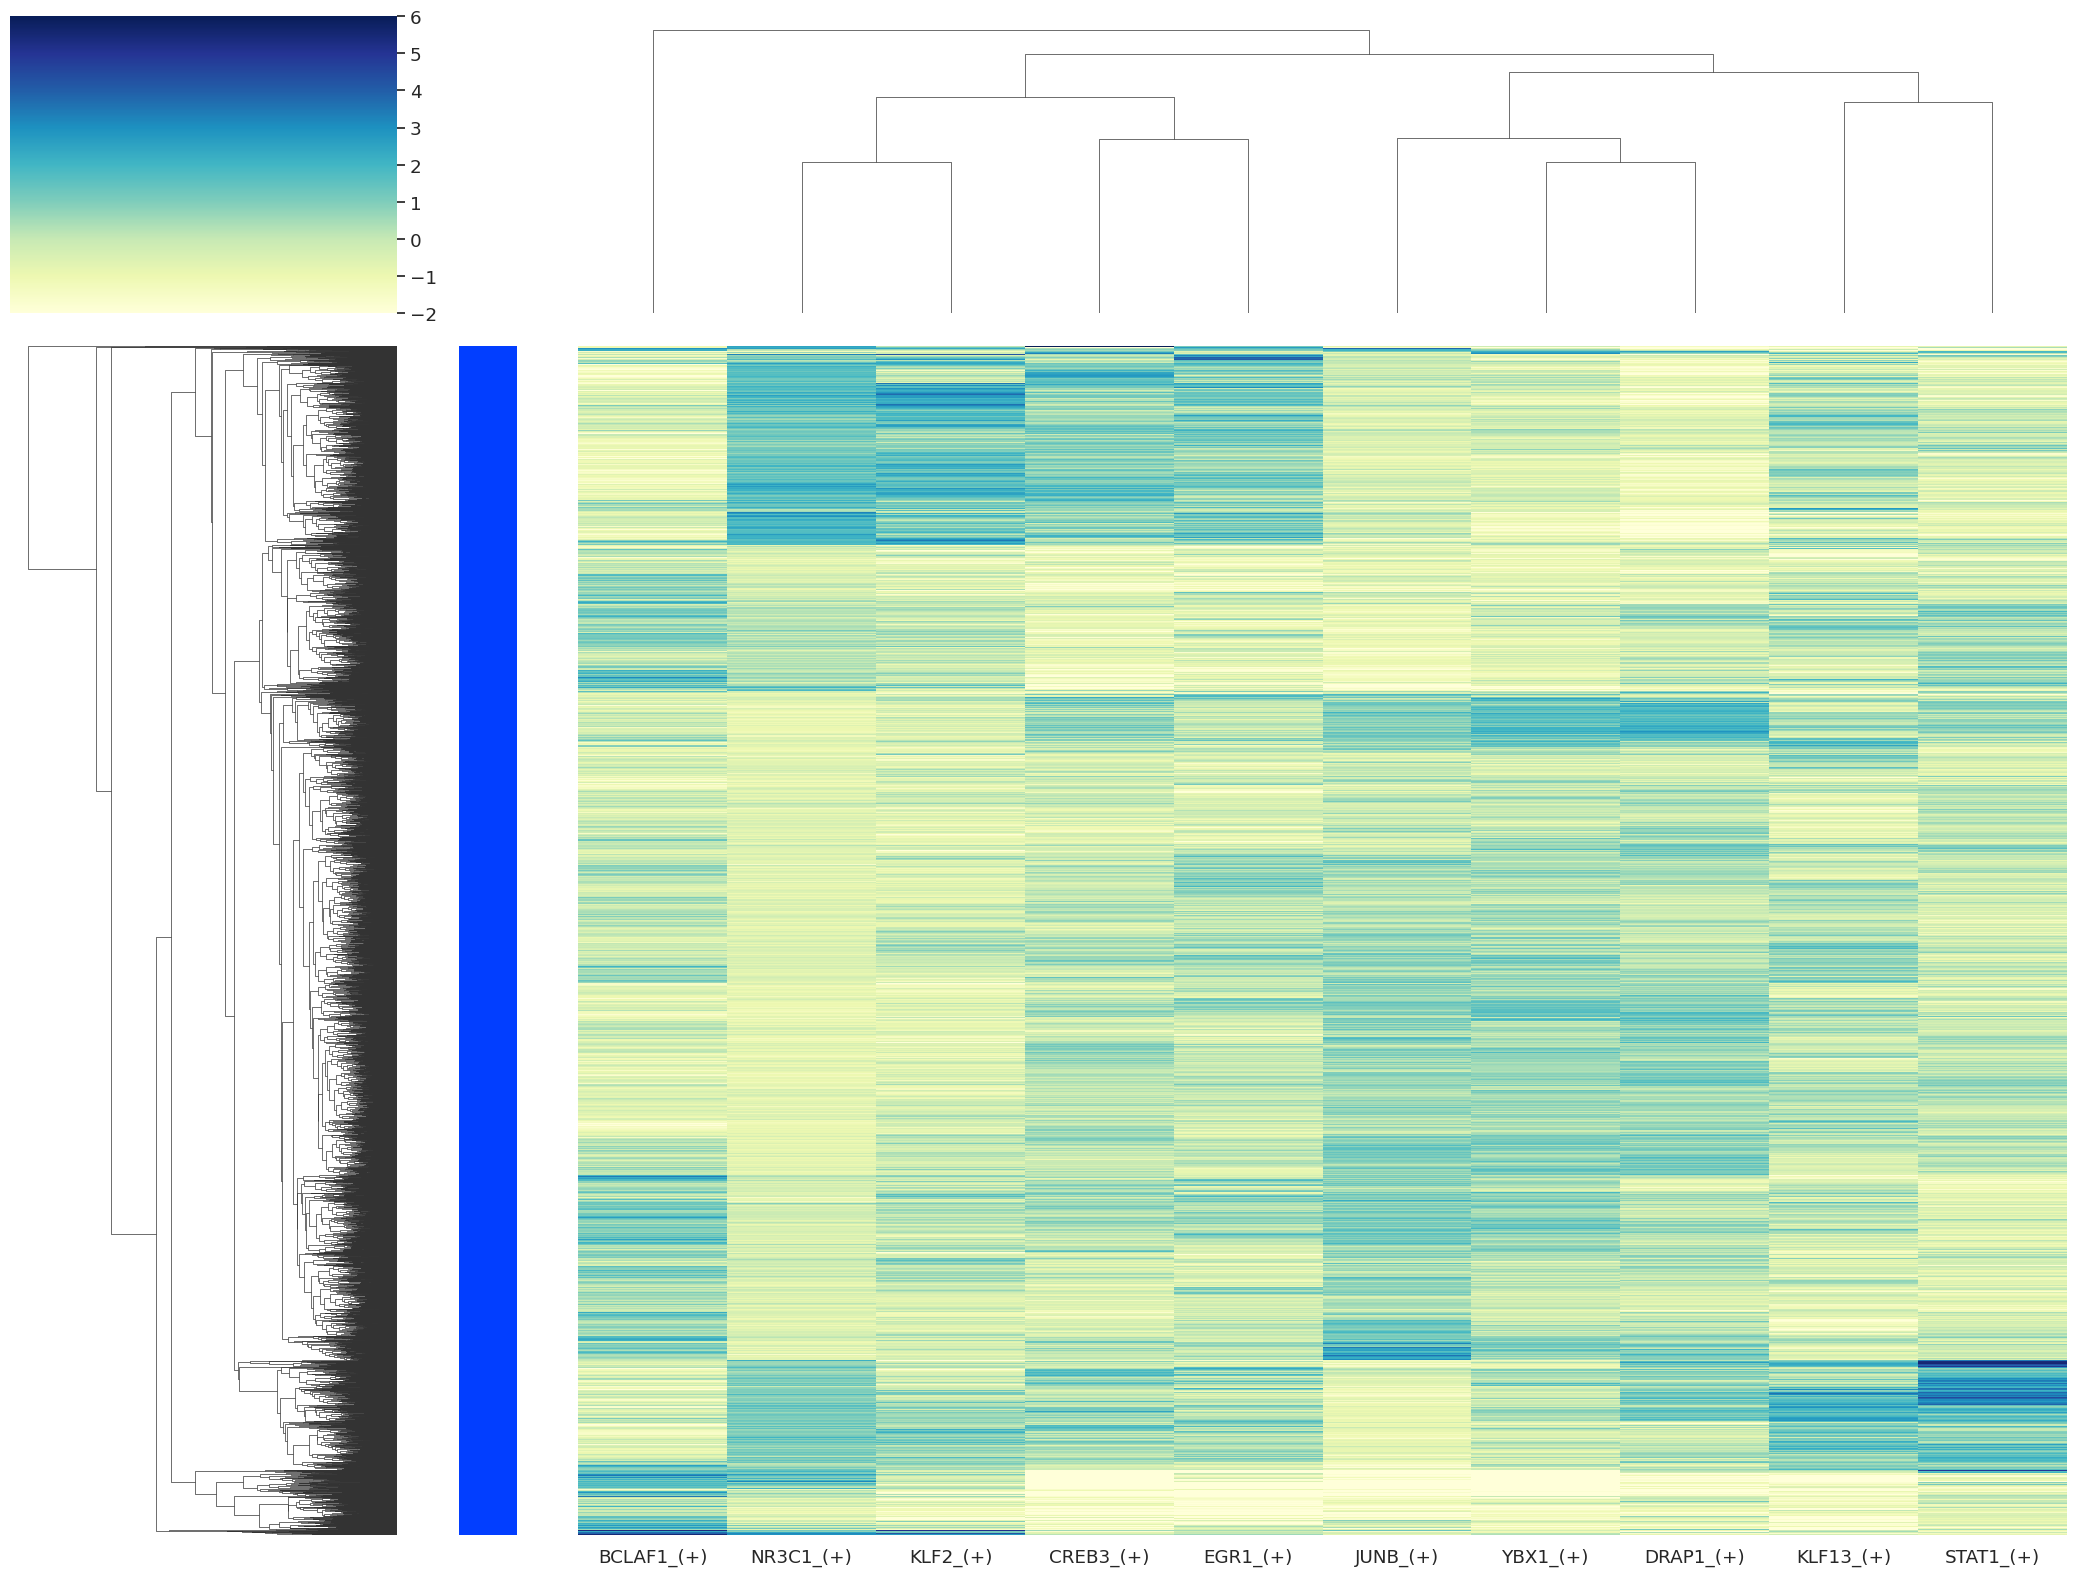

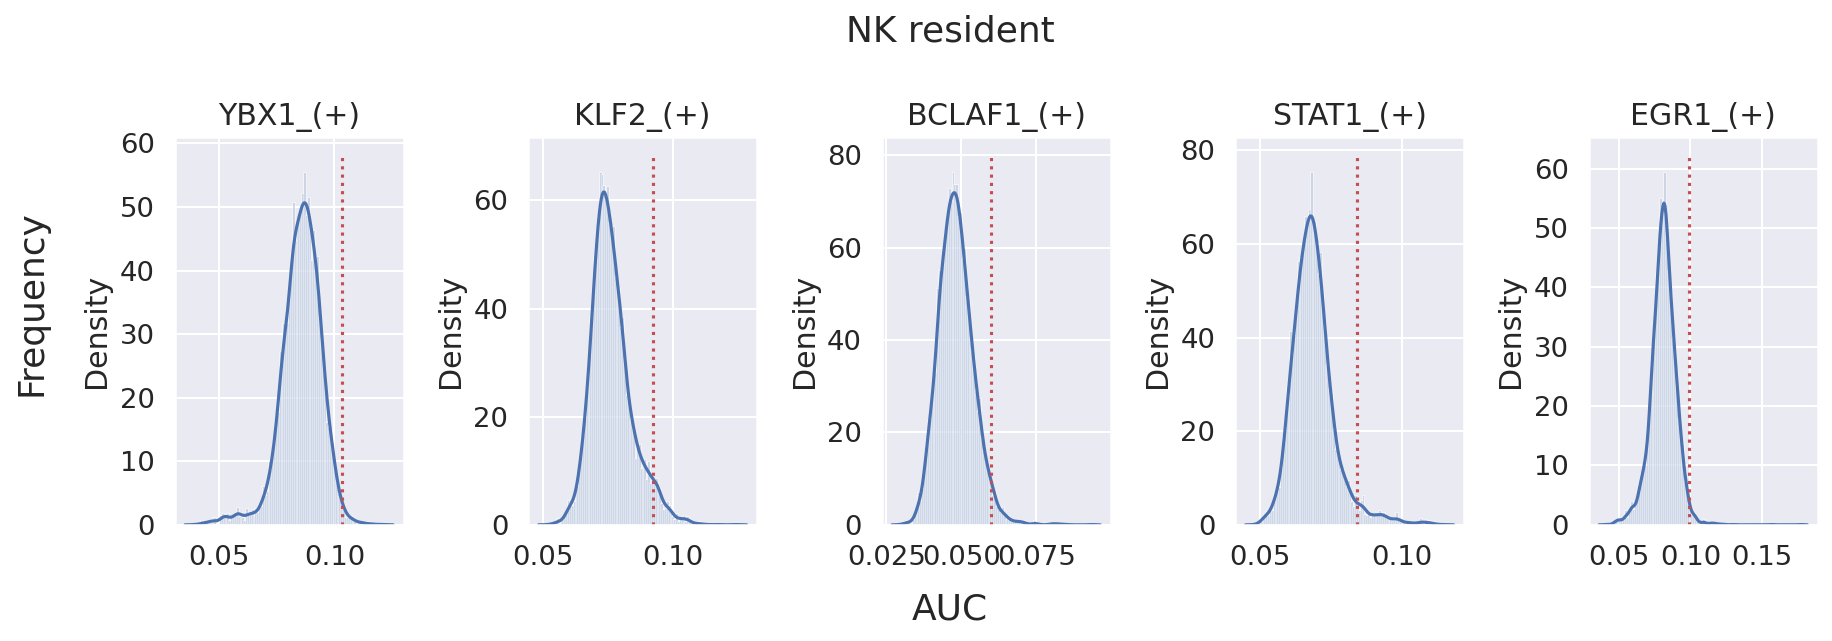

In [18]:
rss_cellType = TF_activity("new_label", 10)
AUC_plot(rss_cellType)

In [19]:
regulons_dict = {}
for i,c in enumerate(rss_cellType):
    genes = list(regulons[c])
    specificity = list(rss_cellType[c].values)
    specificity.extend(genes)
    regulons_dict[c] = specificity

with open("Results/resident_regulons_AUC.json", "w") as outfile:
         json.dump(regulons_dict, outfile)
regulons_df = pd.DataFrame.from_dict(regulons_dict, orient="index").T.to_csv("Results/resident_regulons_AUC.csv", index=False)


In [20]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [21]:
#TFs = sorted(set(df_motifs.index.get_level_values('TF').to_list()))

df = df_motifs.reset_index()
TFs = sorted(set(df["TF"].values))
scores = {}

for t in TFs:
    t_fix = t + "_(+)"
    score = [df[df["TF"] == t]["Enrichment", "NES"].mean()]
    genes = list(regulons[t_fix])
    score.extend(genes)
    scores[t_fix] = score
    
with open("Results/resident_regulons_score.json", "w") as outfile:
         json.dump(scores, outfile)
regulons_df = pd.DataFrame.from_dict(scores, orient="index").T.to_csv("Results/resident_regulons_score.csv", index=False)

In [22]:
pd.DataFrame.from_dict(scores, orient="index").sort_values(0, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840
STAT2_(+),7.735965,AAR2,ABHD14A,ABI1,ACOT9,ACSL5,ACTL6A,ACTR8,ACYP2,ADAM17,...,None,None,None,None,None,None,None,None,None,None
IRF9_(+),5.924025,AAAS,AAK1,ABHD17A,ABHD18,ACAA1,ACBD5,ACSL3,ADAR,ADD1,...,None,None,None,None,None,None,None,None,None,None
IRF7_(+),5.868688,AAMDC,ABHD11,ABHD12,ABHD17A,ABI3,ACAD8,ACADM,ACADS,ACAT2,...,None,None,None,None,None,None,None,None,None,None
STAT1_(+),5.638378,AAAS,AAGAB,AAK1,AAMP,AASDHPPT,ABCB8,ABHD16A,ABHD18,ACAA1,...,None,None,None,None,None,None,None,None,None,None
CREM_(+),4.879989,AASDH,ABCA5,ABCB7,ABCF2,ABHD15,ABHD17A,ABHD17B,ABHD2,ABHD4,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATF7_(+),3.046712,KCNAB2,PHIP,RBPJ,TAB2,TIMM22,ZNF281,None,None,None,...,None,None,None,None,None,None,None,None,None,None
HDAC2_(+),3.032144,APEX1,ASPSCR1,CSTB,DUSP1,ESYT2,GUSB,HPRT1,LATS2,LINC01278,...,None,None,None,None,None,None,None,None,None,None
ZNF675_(+),3.031448,ACTA2,AGPAT3,AKAP9,ALG6,ANXA2,APC,ATF7,CAPRIN1,CBFA2T2,...,None,None,None,None,None,None,None,None,None,None
CTCF_(+),3.028209,AAK1,ABCA5,AK3,AMMECR1,ANP32A,APPL2,ARIH2OS,ASF1A,ATF7,...,None,None,None,None,None,None,None,None,None,None


In [23]:
pd.DataFrame.from_dict(regulons_dict, orient="index").sort_values(0, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840
KLF2_(+),0.963955,AASDHPPT,AATF,ABHD13,ABHD17A,ABHD17B,ABI1,ACAP2,ACBD5,ACP1,...,None,None,None,None,None,None,None,None,None,None
YBX1_(+),0.962506,ABHD12,ABI1,ACADM,ACAP2,ACOT7,ACP1,ACTR2,ACYP2,ADAM10,...,None,None,None,None,None,None,None,None,None,None
STAT1_(+),0.962020,AAAS,AAGAB,AAK1,AAMP,AASDHPPT,ABCB8,ABHD16A,ABHD18,ACAA1,...,None,None,None,None,None,None,None,None,None,None
EGR1_(+),0.960901,A1BG,ABCF1,ACBD5,ACO2,ACTA2,ACTR6,ADPRHL2,AGPAT3,AGTPBP1,...,None,None,None,None,None,None,None,None,None,None
BCLAF1_(+),0.957626,AAR2,ABCB7,ABI1,ACAP2,ACBD3,ACIN1,ACP5,ACSL5,ACYP2,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF605_(+),0.238571,KIAA0100,MMAA,NTPCR,SNAPC2,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
ZNF75A_(+),0.231793,AHCYL1,GPR68,PRIMPOL,TNRC18,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
ZNF333_(+),0.231693,ABR,MIB1,PAICS,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
MYBL1_(+),0.226604,CROT,DNAJC13,RUFY3,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
